In [130]:
import torch
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections

PRINT_IMG = True
AUGMENT_DATASET = False
TRANSFORM_DATASET = False

OPTIMIZER='SGD'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.01
MOMENTUM = 0.9
EPOCHS = 20

In [112]:
def dataset_raw_statistics(dataset):
    class_counts = collections.Counter()
    percentage = {}

    for _, label in dataset:
        class_counts[label] += 1

    for label, count in class_counts.items():
        percentage[label] = (count / len(dataset)) * 100
    
    return class_counts, percentage

In [113]:
def plot_dataset_raw_statistics(dataset, dataset_name="Dataset"):
    class_counts, percentage = dataset_raw_statistics(dataset)

    # Imposta uno stile per i grafici
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    sns.barplot(x=classes, y=counts, hue=classes, palette='viridis', dodge=False, legend=False)
    plt.title(f'Distribuzione delle Classi nel {dataset_name}', fontsize=16)
    plt.ylabel('Numero di campioni')
    plt.xlabel('Classi')
    plt.show()

    plt.figure(figsize=(10, 6))
    percentages = list(percentage.values())
    sns.barplot(x=classes, y=percentages, hue=classes, palette='coolwarm', dodge=False, legend=False)
    plt.title(f'Percentuale delle Classi nel {dataset_name}', fontsize=16)
    plt.ylabel('Percentuale (%)')
    plt.xlabel('Classi')
    plt.show()    

In [114]:
# Definisci la funzione per aggiungere rumore gaussiano
def add_gaussian_noise(tensor, mean=0.0, std=0.05):
    return tensor + std * torch.randn_like(tensor) + mean

In [115]:
# Definisci la funzione per invertire i colori
def invert_colors(tensor):
    return 1 - tensor

In [116]:
def create_train_dataset(transform_dataset=False, augment_dataset=False):
    transform_norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.1307,), (0.3081,))])

    transform_augmented = transforms.Compose([
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomChoice([
            transforms.Lambda(lambda x: add_gaussian_noise(x)),
            transforms.Lambda(lambda x: invert_colors(x)),
            transforms.Lambda(lambda x: x),
        ]),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform_norm)
    
    train_dataset_augmented = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform_augmented)

    print(f"Dimensione del dataset originale: {len(train_dataset)}")
    print(f"Dimensione del dataset trasformato: {len(train_dataset_augmented)}")

    if augment_dataset:
        train_dataset = torch.utils.data.ConcatDataset([train_dataset, train_dataset_augmented])
        print(f"Dimensione del dataset combinato: {len(train_dataset)}")
    
    if transform_dataset:
        train_dataset = train_dataset_augmented

    return train_dataset


In [117]:
def create_test_dataset(validation_split=0.2):
    transform_norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.1307,), (0.3081,))])
    
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_norm)

    total_test_size = len(test_dataset)
 
    validation_size = int(total_test_size * validation_split)
    test_size = total_test_size - validation_size

    test_subset, validation_subset = torch.utils.data.random_split(test_dataset, [test_size, validation_size])
    return test_subset, validation_subset

In [118]:
def create_data_loader(train_dataset, validation_dataset, test_dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, validation_loader, test_loader

In [119]:
train_dataset = create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset, validation_dataset = create_test_dataset(validation_split=0.0)

Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000


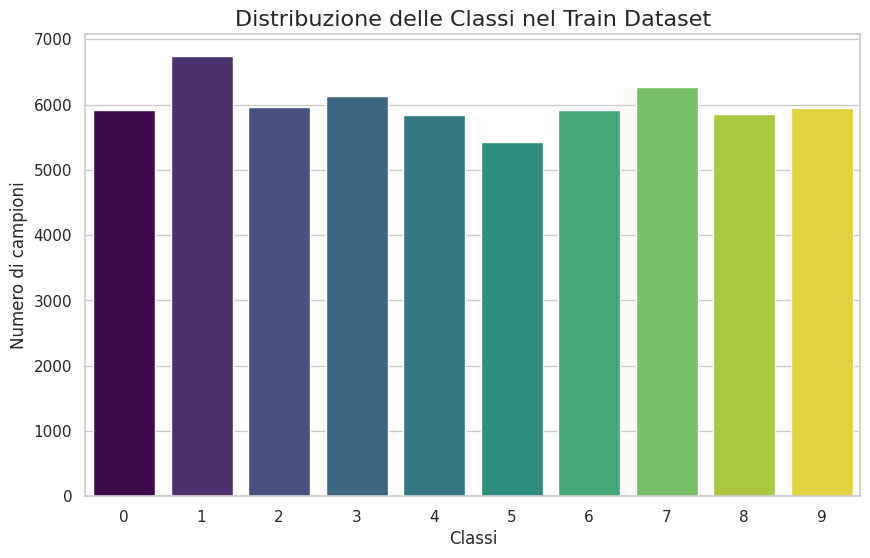

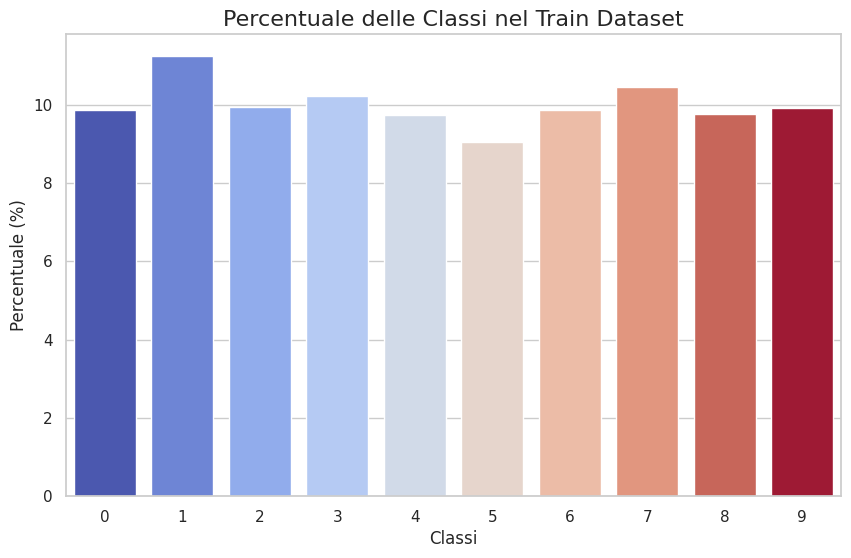

In [120]:
plot_dataset_raw_statistics(train_dataset, "Train Dataset")

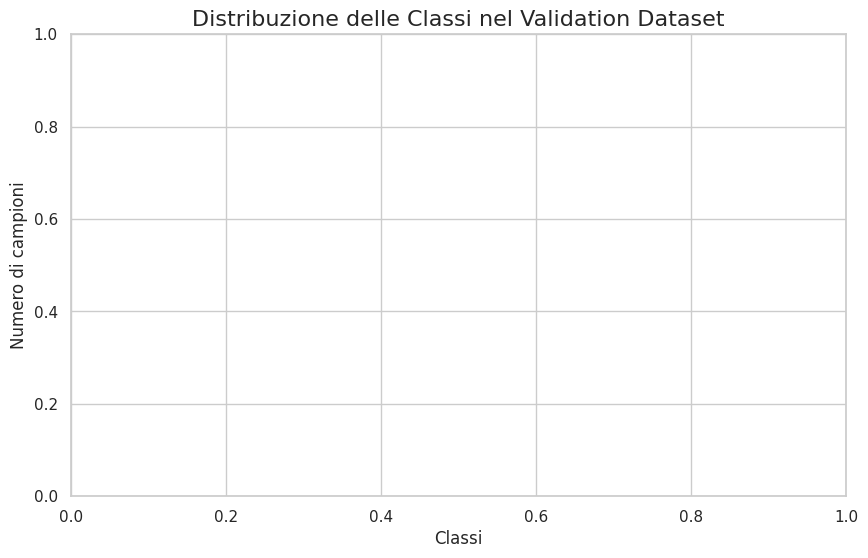

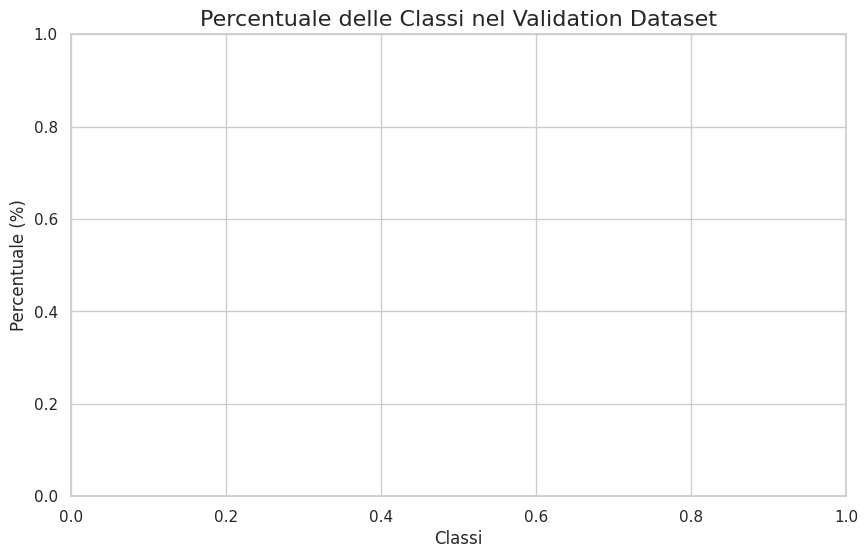

In [121]:
plot_dataset_raw_statistics(validation_dataset, "Validation Dataset")

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


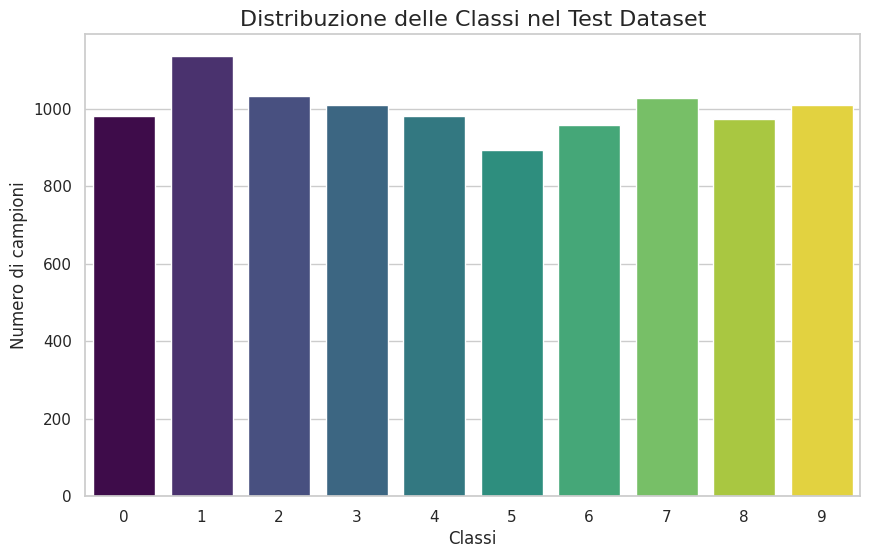

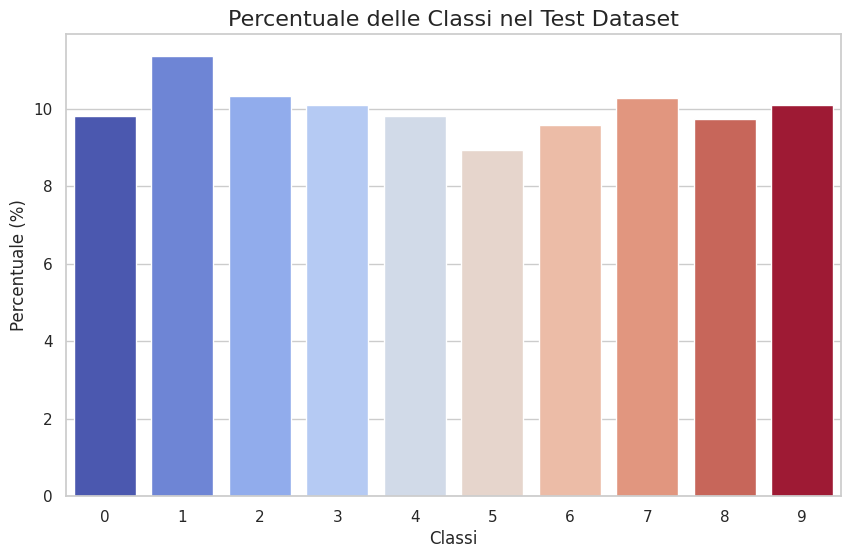

In [122]:
plot_dataset_raw_statistics(test_dataset, "Test Dataset")

In [123]:
train_loader, validation_loader, test_loader = create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [124]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  0  Size validation_dataset:  0
Size test_loader:  79  Size test_dataset:  10000


In [125]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [131]:
import torch.nn as nn
import torch.nn.functional as F

class NumberRecognitionCNN(nn.Module):
    def __init__(self):
        super(NumberRecognitionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # Singola immagine, quindi 1 canale
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 classi per i numeri da 0 a 9

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output con 10 classi (softmax potrebbe essere applicato esternamente)
        return x

model = NumberRecognitionCNN()
print(model)

NumberRecognitionCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [132]:
# define Loss and Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [133]:
# define train and test functions
from tqdm import tqdm

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        img, labels = data

        img, labels = img.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(img)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        img, labels = data

        img, labels = img.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(img)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [134]:
# TRAIN!!!
import time
model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
learning_rates = []
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        # start timer and carry out training and validation
        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(test_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f} learning rate: {current_lr}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f} learning rate: {current_lr}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print()
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")



EPOCH 1 of 20
Training


Loss: 0.0568: 100%|██████████| 469/469 [00:33<00:00, 14.19it/s]


Validating


Loss: 0.4308: 100%|██████████| 79/79 [00:04<00:00, 18.39it/s]


Epoch #1 train loss: 0.492 train accuracy: 84.52 learning rate: 0.01
Epoch #1 validation loss: 0.431 validation accuracy: 96.82 learning rate: 0.01
Took 0.622 minutes for epoch 1

EPOCH 2 of 20
Training


Loss: 0.0719: 100%|██████████| 469/469 [00:32<00:00, 14.63it/s]


Validating


Loss: 0.1386: 100%|██████████| 79/79 [00:04<00:00, 18.94it/s]


Epoch #2 train loss: 0.088 train accuracy: 97.32 learning rate: 0.01
Epoch #2 validation loss: 0.139 validation accuracy: 98.27 learning rate: 0.01
Took 0.604 minutes for epoch 2

EPOCH 3 of 20
Training


Loss: 0.0853: 100%|██████████| 469/469 [00:32<00:00, 14.41it/s]


Validating


Loss: 0.2258: 100%|██████████| 79/79 [00:04<00:00, 15.82it/s]


Epoch #3 train loss: 0.058 train accuracy: 98.22 learning rate: 0.01
Epoch #3 validation loss: 0.226 validation accuracy: 98.28 learning rate: 0.01
Took 0.626 minutes for epoch 3

EPOCH 4 of 20
Training


Loss: 0.1050: 100%|██████████| 469/469 [00:33<00:00, 14.13it/s]


Validating


Loss: 0.1553: 100%|██████████| 79/79 [00:05<00:00, 14.50it/s]


Epoch #4 train loss: 0.046 train accuracy: 98.53 learning rate: 0.01
Epoch #4 validation loss: 0.155 validation accuracy: 98.64 learning rate: 0.01
Took 0.644 minutes for epoch 4

EPOCH 5 of 20
Training


Loss: 0.0755: 100%|██████████| 469/469 [00:35<00:00, 13.23it/s]


Validating


Loss: 0.1689: 100%|██████████| 79/79 [00:04<00:00, 18.39it/s]


Epoch #5 train loss: 0.038 train accuracy: 98.85 learning rate: 0.01
Epoch #5 validation loss: 0.169 validation accuracy: 98.79 learning rate: 0.01
Took 0.663 minutes for epoch 5

EPOCH 6 of 20
Training


Loss: 0.0019: 100%|██████████| 469/469 [00:29<00:00, 16.16it/s]


Validating


Loss: 0.0199: 100%|██████████| 79/79 [00:04<00:00, 19.19it/s]


Epoch #6 train loss: 0.032 train accuracy: 99.02 learning rate: 0.01
Epoch #6 validation loss: 0.020 validation accuracy: 98.82 learning rate: 0.01
Took 0.552 minutes for epoch 6

EPOCH 7 of 20
Training


Loss: 0.0069: 100%|██████████| 469/469 [00:28<00:00, 16.50it/s]


Validating


Loss: 0.1316: 100%|██████████| 79/79 [00:03<00:00, 19.86it/s]


Epoch #7 train loss: 0.026 train accuracy: 99.20 learning rate: 0.01
Epoch #7 validation loss: 0.132 validation accuracy: 99.06 learning rate: 0.01
Took 0.540 minutes for epoch 7

EPOCH 8 of 20
Training


Loss: 0.0184: 100%|██████████| 469/469 [00:28<00:00, 16.25it/s]


Validating


Loss: 0.0474: 100%|██████████| 79/79 [00:04<00:00, 18.15it/s]


Epoch #8 train loss: 0.024 train accuracy: 99.19 learning rate: 0.01
Epoch #8 validation loss: 0.047 validation accuracy: 98.88 learning rate: 0.01
Took 0.554 minutes for epoch 8

EPOCH 9 of 20
Training


Loss: 0.0140: 100%|██████████| 469/469 [00:38<00:00, 12.12it/s]


Validating


Loss: 0.0067: 100%|██████████| 79/79 [00:05<00:00, 15.55it/s]


Epoch #9 train loss: 0.020 train accuracy: 99.33 learning rate: 0.01
Epoch #9 validation loss: 0.007 validation accuracy: 99.08 learning rate: 0.01
Took 0.730 minutes for epoch 9

EPOCH 10 of 20
Training


Loss: 0.0139: 100%|██████████| 469/469 [00:30<00:00, 15.40it/s]


Validating


Loss: 0.0010: 100%|██████████| 79/79 [00:04<00:00, 18.52it/s]


Epoch #10 train loss: 0.018 train accuracy: 99.42 learning rate: 0.01
Epoch #10 validation loss: 0.001 validation accuracy: 98.75 learning rate: 0.01
Took 0.579 minutes for epoch 10

EPOCH 11 of 20
Training


Loss: 0.0020: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]


Validating


Loss: 0.3642: 100%|██████████| 79/79 [00:04<00:00, 18.15it/s]


Epoch #11 train loss: 0.015 train accuracy: 99.56 learning rate: 0.01
Epoch #11 validation loss: 0.364 validation accuracy: 98.99 learning rate: 0.01
Took 0.602 minutes for epoch 11

EPOCH 12 of 20
Training


Loss: 0.0004: 100%|██████████| 469/469 [00:32<00:00, 14.23it/s]


Validating


Loss: 0.1936: 100%|██████████| 79/79 [00:05<00:00, 15.74it/s]


Epoch #12 train loss: 0.012 train accuracy: 99.62 learning rate: 0.01
Epoch #12 validation loss: 0.194 validation accuracy: 98.98 learning rate: 0.01
Took 0.633 minutes for epoch 12

EPOCH 13 of 20
Training


Loss: 0.0111: 100%|██████████| 469/469 [00:31<00:00, 14.93it/s]


Validating


Loss: 0.0086: 100%|██████████| 79/79 [00:04<00:00, 17.30it/s]


Epoch #13 train loss: 0.012 train accuracy: 99.61 learning rate: 0.01
Epoch #13 validation loss: 0.009 validation accuracy: 98.98 learning rate: 0.01
Took 0.600 minutes for epoch 13

EPOCH 14 of 20
Training


Loss: 0.0017: 100%|██████████| 469/469 [00:30<00:00, 15.57it/s]


Validating


Loss: 0.2144: 100%|██████████| 79/79 [00:04<00:00, 17.58it/s]


Epoch #14 train loss: 0.010 train accuracy: 99.70 learning rate: 0.01
Epoch #14 validation loss: 0.214 validation accuracy: 99.05 learning rate: 0.01
Took 0.577 minutes for epoch 14

EPOCH 15 of 20
Training


Loss: 0.0108: 100%|██████████| 469/469 [00:29<00:00, 16.11it/s]


Validating


Loss: 0.1248: 100%|██████████| 79/79 [00:03<00:00, 20.27it/s]


Epoch #15 train loss: 0.012 train accuracy: 99.64 learning rate: 0.01
Epoch #15 validation loss: 0.125 validation accuracy: 98.87 learning rate: 0.01
Took 0.550 minutes for epoch 15

EPOCH 16 of 20
Training


Loss: 0.0004: 100%|██████████| 469/469 [00:30<00:00, 15.56it/s]


Validating


Loss: 0.0175: 100%|██████████| 79/79 [00:04<00:00, 18.03it/s]


Epoch #16 train loss: 0.008 train accuracy: 99.75 learning rate: 0.001
Epoch #16 validation loss: 0.017 validation accuracy: 99.05 learning rate: 0.001
Took 0.575 minutes for epoch 16

EPOCH 17 of 20
Training


Loss: 0.0002: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s]


Validating


Loss: 0.0197: 100%|██████████| 79/79 [00:05<00:00, 15.79it/s]


Epoch #17 train loss: 0.003 train accuracy: 99.91 learning rate: 0.001
Epoch #17 validation loss: 0.020 validation accuracy: 99.21 learning rate: 0.001
Took 0.617 minutes for epoch 17

EPOCH 18 of 20
Training


Loss: 0.0049: 100%|██████████| 469/469 [00:34<00:00, 13.52it/s]


Validating


Loss: 0.0363: 100%|██████████| 79/79 [00:04<00:00, 18.54it/s]


Epoch #18 train loss: 0.002 train accuracy: 99.95 learning rate: 0.001
Epoch #18 validation loss: 0.036 validation accuracy: 99.20 learning rate: 0.001
Took 0.649 minutes for epoch 18

EPOCH 19 of 20
Training


Loss: 0.0021: 100%|██████████| 469/469 [00:34<00:00, 13.42it/s]


Validating


Loss: 0.0373: 100%|██████████| 79/79 [00:04<00:00, 18.18it/s]


Epoch #19 train loss: 0.002 train accuracy: 99.96 learning rate: 0.001
Epoch #19 validation loss: 0.037 validation accuracy: 99.15 learning rate: 0.001
Took 0.655 minutes for epoch 19

EPOCH 20 of 20
Training


Loss: 0.0002: 100%|██████████| 469/469 [00:32<00:00, 14.33it/s]


Validating


Loss: 0.0383: 100%|██████████| 79/79 [00:04<00:00, 17.15it/s]


Epoch #20 train loss: 0.002 train accuracy: 99.96 learning rate: 0.001
Epoch #20 validation loss: 0.038 validation accuracy: 99.20 learning rate: 0.001
Took 0.622 minutes for epoch 20
Validating


Loss: 0.0383: 100%|██████████| 79/79 [00:04<00:00, 17.67it/s]


Test loss: 0.038 Test accuracy: 99.20


In [135]:
# Salva i pesi del modello in un file .pth
torch.save(model.state_dict(), 'weights/lenet5_best_weights.pth')